In [73]:
import cv2
import numpy as np

In [74]:
def black_level_substraction(img):
    img -= 2048
    img[img < 0] = 0
    return img

In [75]:
img_path = '../data/processed/SimpleCube++/train/PNG/00_0002.png'
img = np.array(cv2.imread(img_path,  cv2.IMREAD_UNCHANGED))
img = img.astype(np.float64)
img = black_level_substraction(img)
img.mean()

730.6213694082456

In [76]:
img_path = '../data/processed/ColorChecker/train/PNG/88_IMG_0282.png'
img = np.array(cv2.imread(img_path,  cv2.IMREAD_UNCHANGED))
img.mean()

22.437215169270832

In [77]:
img_path = '../data/processed/TCC/train/PNG/3_10.png'
img = np.array(cv2.imread(img_path,  cv2.IMREAD_UNCHANGED))
img[0].mean()

21.005144032921812

In [86]:
img_path = '../data/raw/TCC/training/3/10.png'
img = np.array(cv2.imread(img_path,  cv2.IMREAD_UNCHANGED))
img[0].mean()

20.893823099415204

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import sys
sys.path.append('/Users/kirillprosvirin/GitLab/mlops-project')

from src.models.baseline.hough_wasserstein import calculate_mean_wasserstein
from skopt import gp_minimize

EPS = 1e-6

In [3]:
# Upload target data
wp_t = []
wp_t = np.load('../data/processed/wp_t.npy')

# Upload source data
wp_s = []
wp_s = np.load('../data/processed/wp_s.npy')

In [11]:
(normolize_wp(wp_t) / normolize_wp(wp_t).sum(axis=1).reshape(-1, 1))[0]

array([0.17351585, 0.43606481, 0.39041934])

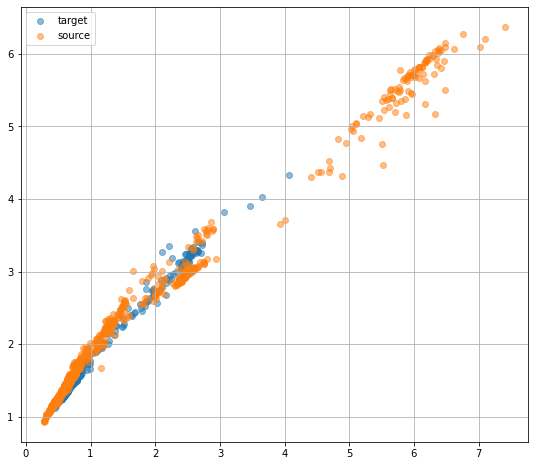

In [7]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.scatter((normolize_wp(wp_t)[:, 0]), (normolize_wp(wp_t)[:, 1]), alpha=0.5, label='target')
plt.scatter((normolize_wp(wp_s)[:, 0]), (normolize_wp(wp_s)[:, 1]), alpha=0.5, label='source')
plt.legend()
plt.grid()

# plt.subplot(1, 2, 2)
# plt.scatter((wp_t_new[:, 0]), (wp_t_new[:, 1]), alpha=0.5, label='target_new')
# plt.scatter((wp_s[:, 0]), (wp_s[:, 1]), alpha=0.5, label='source')
# plt.legend()
# plt.grid()

plt.show()

In [60]:
def dist2binary_hist(dist1, dist2, bins=100):
    hist_s = np.histogram2d((dist1[:, 0]), (dist1[:, 1]), bins=bins)[0]
    hist_t = np.histogram2d((dist2[:, 0]), (dist2[:, 1]), bins=bins)[0]

    # Convert histograms to binary
    hist_s = (hist_s > 0).astype(int)
    hist_t = (hist_t > 0).astype(int)
    
    return hist_s, hist_t

def normolize_wp(wp):
    return wp / (wp[:, 2].reshape(-1, 1) + EPS)

def inv_normolize_wp(wp_normed):
    return wp_normed / wp_normed.sum(axis=1).reshape(-1, 1)

def apply_projective_matrix(wp, params):
    assert len(params) == 3*3
    projective_matrix = np.array(params).reshape(3, 3)
    return wp @ projective_matrix

def objective(params, wp_t=wp_t, wp_s=wp_s):
    # Normolize white points by deviding on third component
    wp_t = normolize_wp(wp_t)
    wp_s = normolize_wp(wp_s)

    # Apply the projective transformation to white points
    transformed_wp_t = apply_projective_matrix(wp_t, params)

    # New target white points need to be normolized
    transformed_wp_t = normolize_wp(transformed_wp_t)

    # Make 2D binary histograms for computing Wasserstein distance
    transformed_hist_t, hist_s = dist2binary_hist(transformed_wp_t, wp_s)
    
    # Calculate the mean Wasserstein distance
    distance = calculate_mean_wasserstein(transformed_hist_t, hist_s)
    
    return distance

In [ ]:
bounds = [(0.5, 2)]*4 + [(-100, 100)]*2 + [(-0.001, 0.001)]*2 + [(0.9, 1.1)]  # [(-i, i)]*9
for j in range(10):
    res = gp_minimize(objective, dimensions=bounds, initial_point_generator='sobol', n_jobs=4)
    print(res['fun'], res['x'])

# Output:
# 4.622126738626478 [0.5, 0.5, 0.5, 2.0, 12, 27, -0.001, 0.001, 1.087887012197486]
# 4.600354623556748 [0.5, 2.0, 0.5, 2.0, 45, 23, -0.0009048960553778023, 0.001, 0.9]
# 4.789727322088261 [0.5, 1.7349842836377658, 0.5, 1.920421835950059, 62, 47, -0.001, -0.001, 0.9]
# 4.8438893826761396 [0.5, 1.4722452555585082, 0.7995020635621719, 2.0, 49, 59, -0.001, -0.001, 1.1]
# 4.7903221048693405 [0.5, 2.0, 1.0789042844465608, 2.0, 49, 40, 0.001, 0.001, 1.1]
# 4.883236637678317 [1.2221551751081368, 1.696693764970462, 2.0, 1.4316755117374877, 8, 13, -7.715224743229387e-05, 0.0007866238037543777, 1.0669831397663403]
# 4.793171724431398 [0.5, 0.5, 0.9723749722573025, 2.0, 16, 62, 0.001, 0.001, 1.0854321280731316]
# 5.293903598434864 [2.0, 2.0, 0.5, 0.5, 83, 60, -0.001, 0.001, 1.057830640866368]
# 4.695912808192593 [0.5, 2.0, 2.0, 2.0, 28, 43, 0.001, -0.001, 1.1]
# 4.889752540924619 [0.5, 0.5, 1.0037262766761361, 1.9351192986948227, 16, 62, -0.00054973016663984, -0.001, 1.1]

In [68]:
output = [-4, -1, -2, -1, -4, 1, 3, 4, -4]
H = np.array(output).reshape(3, 3)
wp_t_new = normolize_wp(normolize_wp(wp_t) @ H)

In [69]:
inv_normolize_wp(wp_t_new)

array([[-0.02300824,  0.19920301,  0.82380523],
       [ 0.17982158,  0.3248362 ,  0.49534222],
       [ 0.37133105,  0.41984087,  0.20882808],
       ...,
       [ 0.11369307,  0.28947866,  0.59682828],
       [ 0.36147776,  0.40484785,  0.23367439],
       [ 0.21125603,  0.36870852,  0.42003544]])

In [70]:
wp_t_new

array([[-0.02792923,  0.24180845,  1.00000027],
       [ 0.36302502,  0.65578153,  1.00000025],
       [ 1.77816656,  2.01046206,  1.00000018],
       ...,
       [ 0.19049549,  0.48502851,  1.00000026],
       [ 1.54692956,  1.73253014,  1.00000018],
       [ 0.50294824,  0.87780358,  1.00000025]])

Wass_dist = 13.27463964162448
Wass_dist_new = 13.946568837272684


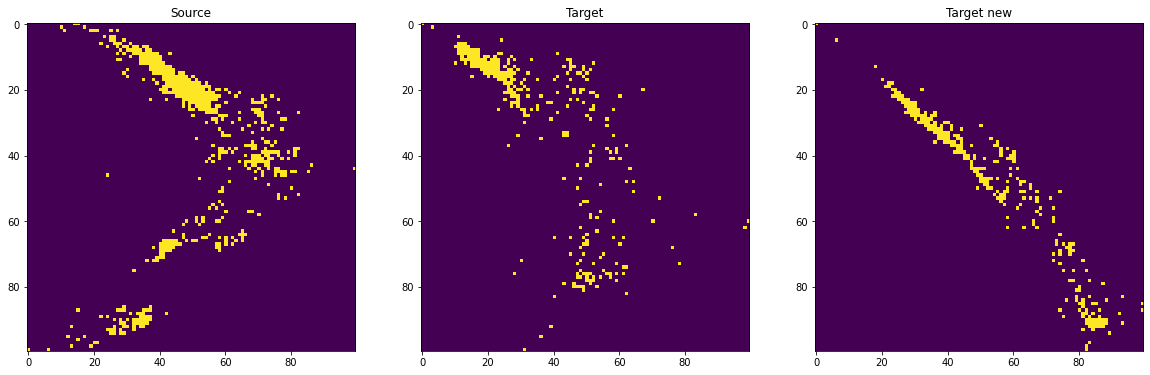

In [71]:
hist_s, hist_t = dist2binary_hist(inv_normolize_wp(normolize_wp(wp_s)), inv_normolize_wp(normolize_wp(wp_t)))
hist_s, hist_t_new = dist2binary_hist(inv_normolize_wp(normolize_wp(wp_s)), inv_normolize_wp(normolize_wp(wp_t_new)))

plt.figure(figsize=(20, 8))

plt.subplot(1, 3, 1)
plt.imshow(hist_s)
plt.title('Source')

plt.subplot(1, 3, 2)
plt.imshow(hist_t)
plt.title('Target')

plt.subplot(1, 3, 3)
plt.imshow(hist_t_new)
plt.title('Target new')

print('Wass_dist =', calculate_mean_wasserstein(hist_s, hist_t))
print('Wass_dist_new =', calculate_mean_wasserstein(hist_s, hist_t_new))

In [65]:
wp_t_new

array([[-0.02792923,  0.24180845,  1.00000027],
       [ 0.36302502,  0.65578153,  1.00000025],
       [ 1.77816656,  2.01046206,  1.00000018],
       ...,
       [ 0.19049549,  0.48502851,  1.00000026],
       [ 1.54692956,  1.73253014,  1.00000018],
       [ 0.50294824,  0.87780358,  1.00000025]])

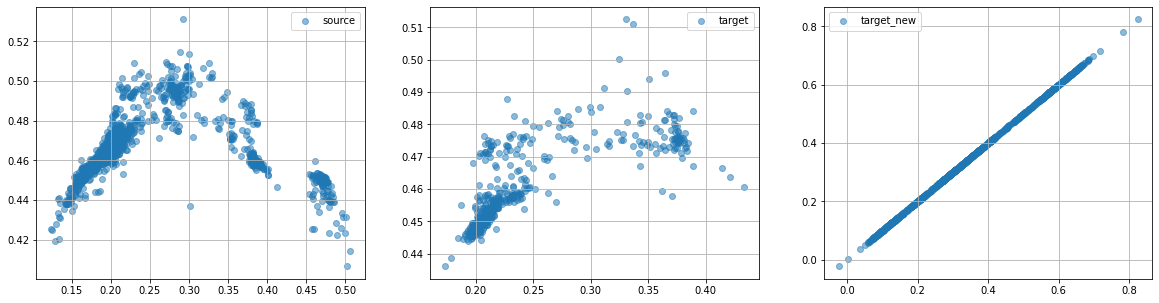

In [64]:
plt.figure(figsize=(20, 5))

plt.subplot(1, 3, 1)
# plt.scatter((wp_t_2d[:, 0]), (wp_t_2d[:, 1]), alpha=0.5, label='target')
plt.scatter((wp_s[:, 0]), (wp_s[:, 1]), alpha=0.5, label='source')
plt.legend()
plt.grid()

plt.subplot(1, 3, 2)
plt.scatter((wp_t[:, 0]), (wp_t[:, 1]), alpha=0.5, label='target')
# plt.scatter((wp_s[:, 0]), (wp_s[:, 1]), alpha=0.5, label='source')
plt.legend()
# plt.xlim([-10, 10])
# plt.ylim([-75, 50])
plt.grid()

plt.subplot(1, 3, 3)
plt.scatter(inv_normolize_wp(wp_t_new), inv_normolize_wp(wp_t_new), alpha=0.5, label='target_new')
# plt.scatter((wp_s[:, 0]), (wp_s[:, 1]), alpha=0.5, label='source')
plt.legend()
# plt.xlim([-10, 10])
# plt.ylim([-75, 50])
plt.grid()

plt.show()

In [ ]:
# For not bin histograms
# 1 -- 6.854462494738358 [1, 0, 0, 1, 1, 0, 0, 0, 0]
# 1 -- 6.075399639902182 [1, 0, 0, 0, 0, 0, 0, -1, 0]
# 1 -- 6.075399639902182 [1, 1, 0, 0, 1, 0, 0, 0, 0]
# 1 -- 14.213955673689533 [1, 1, 0, 0, -1, 1, 1, 1, -1]
# 1 -- 5.527603620265838 [1, 1, -1, 1, 1, 1, 1, 1, 1]

# 2 -- 4.473758367933332 [-2, 1, 2, -2, -2, -2, -1, 1, -2]
# 2 -- 7.488972828922446 [-1, 1, -1, 2, 1, 1, 0, -2, -1]
# 2 -- 12.052895277436166 [-1, -2, 2, 0, 2, 1, 1, -1, -2]
# 2 -- 14.575694226991885 [0, -2, -1, 2, 1, -2, 0, 0, 0]
# 2 -- 7.947511171022976 [1, 1, 1, -2, -1, -1, 1, 0, 0]

# 3 -- 4.43808033434512 [-1, -3, 2, 0, 1, -2, -3, 3, -2]
# 3 -- 4.295870631078742 [1, -2, 2, -2, 1, -2, -3, 2, -1]
# 3 -- 5.188477623392216 [3, 3, -2, -1, 2, 3, 1, 3, 0]
# 3 -- 5.287260659825808 [-2, -3, 1, 0, 2, -1, 0, 3, 0]
# 3 -- 8.793076088966714 [-3, -3, 0, 3, 3, -3, 0, 0, -1]

# 4 -- 5.527603620265838 [4, 4, -4, 3, -3, 4, 3, -3, 4]
# 4 -- 6.677806656936927 [-1, -2, -1, 0, -4, 1, -4, 1, -2]
# 4 -- 5.3810649857925394 [2, 3, -2, 0, 3, 3, 2, -2, 3]
# 4 -- 5.60321571482712 [-2, -4, 1, 1, -2, -2, -1, -3, -4]
# 4 -- 4.530272177668253 [4, 4, -4, -1, -1, 4, 4, -4, 3]

# 8 -- 4.672404038677993 [8, 8, -5, 2, 4, 6, 8, -8, 3]

# For histograms
# 1 -- 9.593845856243863 [-1, 0, -1, 0, 1, -1, -1, -1, 0]
# 1 -- 9.438912581699336 [-1, -1, -1, 0, 0, -1, -1, -1, 1]
# 1 -- 8.572738229907333 [1, 0, 0, 1, 1, 0, 0, 1, 0]
# 1 -- 6.081901413478034 [1, 0, 0, 1, 1, 1, -1, 0, 0]
# 1 -- 8.72879535361153 [-1, -1, -1, -1, 0, 0, 0, 1, -1]

# 2 -- 5.74951629845486 [1, 1, -1, 1, -2, 2, -2, -2, 1]
# 2 -- 4.396200656188417 [-2, -1, -1, 2, -2, -2, 2, 2, -2]
# 2 -- 4.779065326379297 [-2, -2, -1, 0, -2, -2, 0, 2, -2]
# 2 -- 5.011190953654196 [-1, 0, 0, -1, -2, -1, -1, 1, -2]
# 2 -- 8.534381178942159 [-2, -2, -1, -2, -2, 1, 0, 2, -2]

# 3 -- 4.429994747899149 [-3, 0, 0, 1, 0, -2, 3, 2, -1]
# 3 -- 7.703496891180691 [-2, 0, 0, 3, -1, -1, 2, 1, -1]
# 3 -- 8.684031456785606 [3, 3, 0, 0, 1, 3, 2, 3, 3]
# 3 -- 4.780645477888125 [3, 3, 3, -1, -1, 3, 0, -3, 0]
# 3 -- 5.657127299972137 [-3, -3, 0, -1, -2, -3, 1, 3, 1]

# 4 -- 8.264526632725158 [2, 0, 0, -4, -2, -2, 2, -1, -3]
# 4 -- 3.703896798080951 [-1, 3, 2, 1, 3, -1, -4, -1, 4]
# 4 -- 4.441411072722952 [-4, 0, -2, -3, 1, -4, -1, 3, -2]
# 4 -- 3.925309276554249 [2, 3, 2, -2, 3, 1, -4, -1, 3]
# 4 -- 3.868561706597561 [-4, -1, -2, -1, -4, 1, 3, 4, -4]

# 8 -- 4.611669852367162 [5, -1, 6, -1, 1, 2, -6, -2, 7]